In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

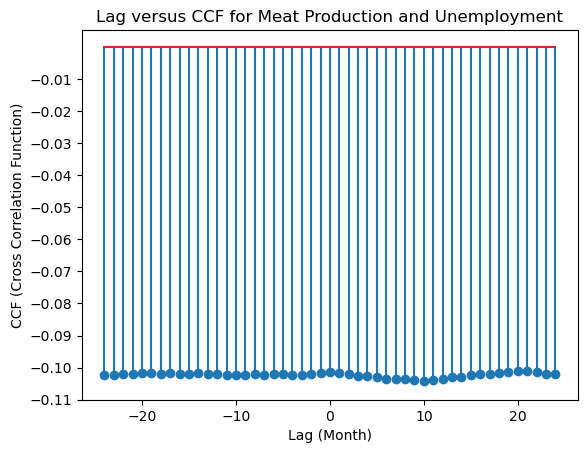

In [16]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1 = (economic_df['state'] == 'Nebraska') | (economic_df['state'] == 'Iowa') | (economic_df['state'] == 'Texas') | (economic_df['state'] == 'Kansas') | (economic_df['state'] == 'Illinois')
condition_2 = (economic_df['state'] == 'Georgia') | (economic_df['state'] == 'Arkansas') | (economic_df['state'] == 'North Carolina') | (economic_df['state'] == 'Alabama') | (economic_df['state'] == 'Mississippi')
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 24
lags = np.arange(-num, num + 1)

# Calculating cross-correlation for negative lags
neg_ccf = ccf(data['unemployment_rate'], data['Production'])
neg_ccf = neg_ccf[:num + 1][::-1]

# Combine with non-negative lags
pos_ccf = ccf(data['Production'], data['unemployment_rate'])
all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

plt.stem(lags, all_ccf)
plt.xlabel('Lag (Month)')
plt.ylabel('CCF (Cross Correlation Function)')
plt.yticks(np.arange(-0.11, 0, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus CCF for Meat Production and Unemployment')
# plt.savefig('Red Meat Cold Storage.png')
plt.show()